In [1]:
import matplotlib.pyplot as plt

from livae.utils import load_image_from_h5
from livae.data import PatchDataset

%load_ext autoreload
%autoreload 2

In [2]:
images = []

# open data files and load all h5 files
data_dir = "../data/"
file_names = [
    "HAADF1.h5",
    "HAADF2.h5",
    "HAADF3.h5",
]
for file_name in file_names:
    file_path = data_dir + file_name
    image = load_image_from_h5(file_path, "Measurement_000/Channel_000/HAADF/HAADF")
    images.append(image)
    print(f"Loaded {file_name} with shape {image.shape}")

Loaded HAADF1.h5 with shape (2048, 2048)
Loaded HAADF2.h5 with shape (2048, 2048)
Loaded HAADF3.h5 with shape (2048, 2048)


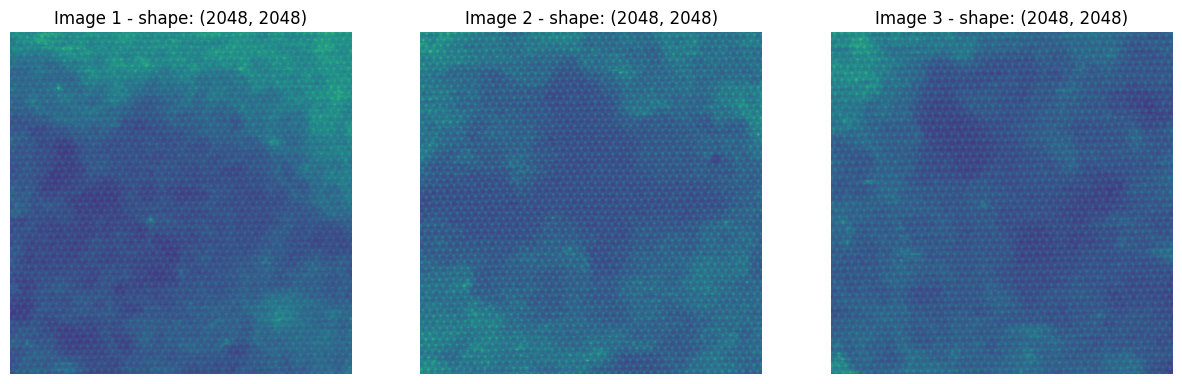

In [3]:
fig = plt.figure(figsize=(15, 5))
for i, image in enumerate(images):
    ax = fig.add_subplot(1, len(images), i + 1)
    ax.imshow(image)
    ax.set_title(f"Image {i + 1} - shape: {image.shape}")
    ax.axis("off")
plt.show()

In [4]:
ds = PatchDataset(images, patch_size=128)
print(f"Created PatchDataset with {len(ds)} patches")

Preprocessing images (caching)...
Detected 4916 atoms, 4363 after edge exclusion.
Detected 4959 atoms, 4370 after edge exclusion.
Detected 4776 atoms, 4198 after edge exclusion.
Created PatchDataset with 12931 patches


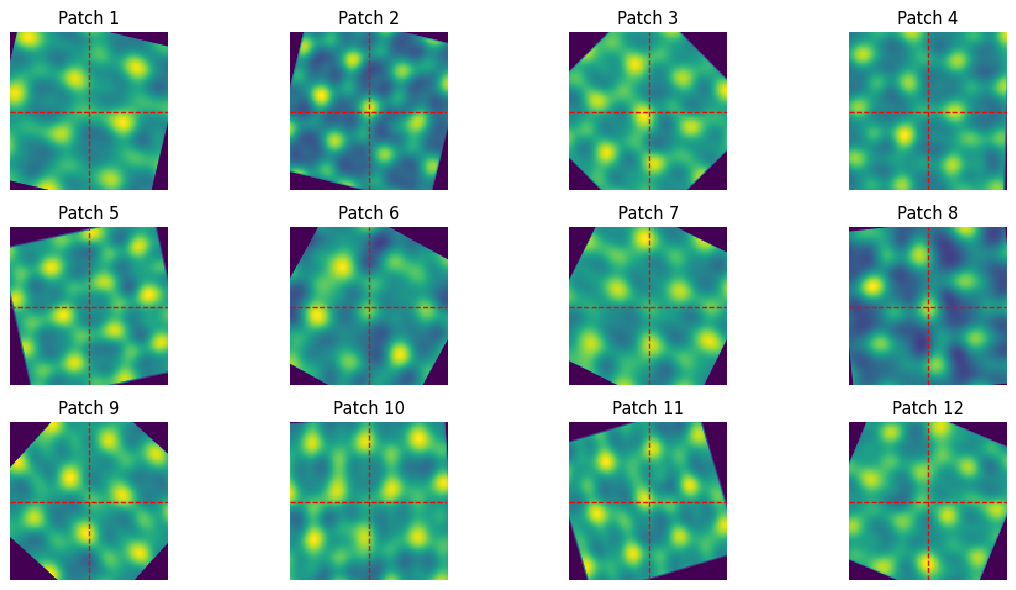

In [5]:
import random
fig = plt.figure(figsize=(12, 6))
for i in range(12):
    random_index = random.randint(0, len(ds) - 1)
    patch = ds[random_index]
    patch_img = patch.squeeze()
    ax = fig.add_subplot(3, 4, i + 1)
    ax.imshow(patch_img, interpolation='none')
    # plot center crosshairs
    center = patch_img.shape[0] // 2
    ax.axhline(center, color='red', linestyle='--', linewidth=1)
    ax.axvline(center, color='red', linestyle='--', linewidth=1)
    ax.set_title(f"Patch {i + 1}")
    ax.axis("off")
plt.tight_layout()
plt.show()

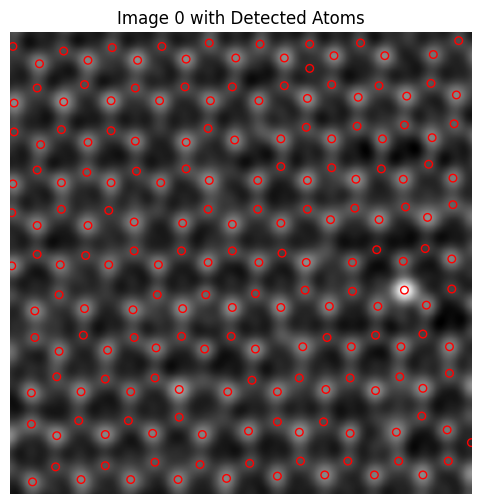

In [6]:
ds.plot_peaks(0, size=400, offset=(900,500))

In [7]:
from livae.data import AdaptiveLatticeDataset

# Create adaptive lattice dataset
adaptive_ds = AdaptiveLatticeDataset(images, patch_size=128, detection_threshold=0.6)
print(f"Created AdaptiveLatticeDataset with {len(adaptive_ds)} patches")

Adaptive lattice: 6017 unique sites - 4654 with atoms, 1363 empty sites
Adaptive lattice: 6026 unique sites - 4880 with atoms, 1146 empty sites
Adaptive lattice: 5595 unique sites - 4250 with atoms, 1345 empty sites
Created AdaptiveLatticeDataset with 17638 patches


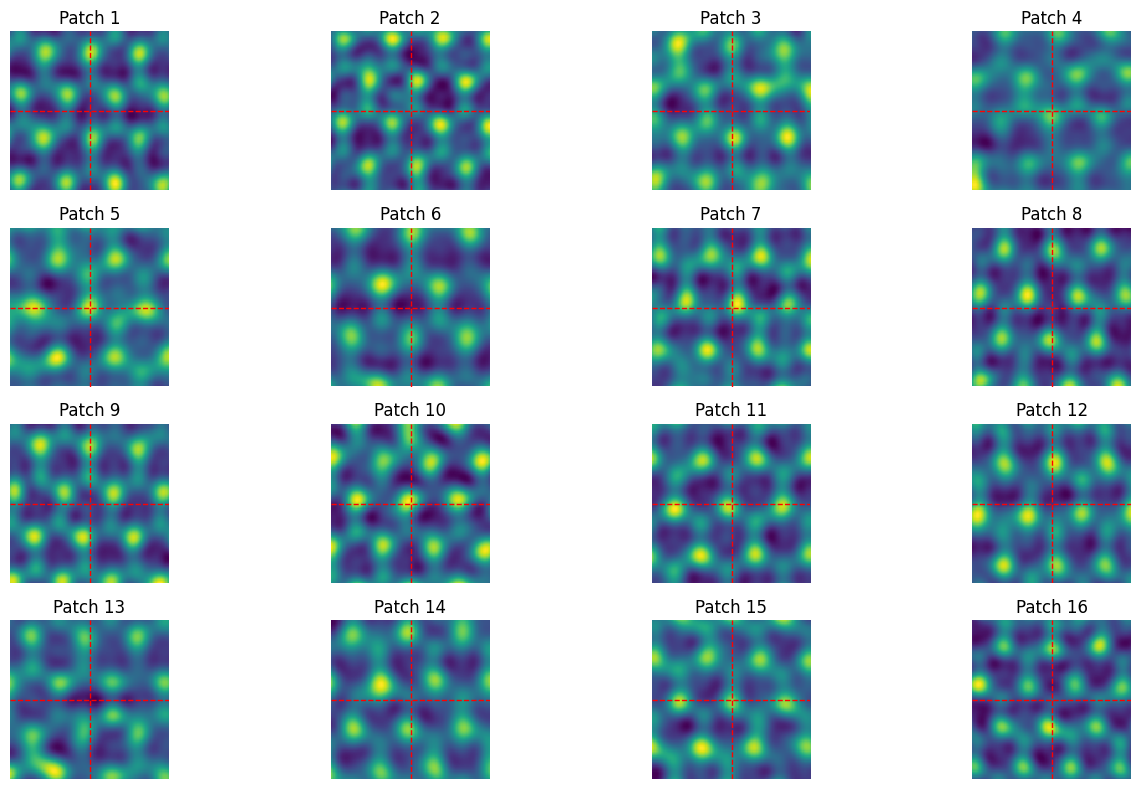

In [8]:
# Sample patches from adaptive dataset
fig = plt.figure(figsize=(14, 8))
for i in range(16):
    random_index = random.randint(0, len(adaptive_ds) - 1)
    patch = adaptive_ds[random_index]
    patch_img = patch.squeeze()
    
    ax = fig.add_subplot(4, 4, i + 1)
    ax.imshow(patch_img, interpolation='none')
    
    # Color-code by label
    # title_color = 'green' if label == 1 else 'red' label_text = 'Atom' if label == 1 else 'Empty Site'
    # ax.set_title(f"{label_text}", color=title_color, fontweight='bold')
    center = patch_img.shape[0] // 2
    ax.axhline(center, color='red', linestyle='--', linewidth=1)
    ax.axvline(center, color='red', linestyle='--', linewidth=1)
    ax.set_title(f"Patch {i + 1}")
    ax.axis("off")
    
plt.tight_layout()
plt.show()

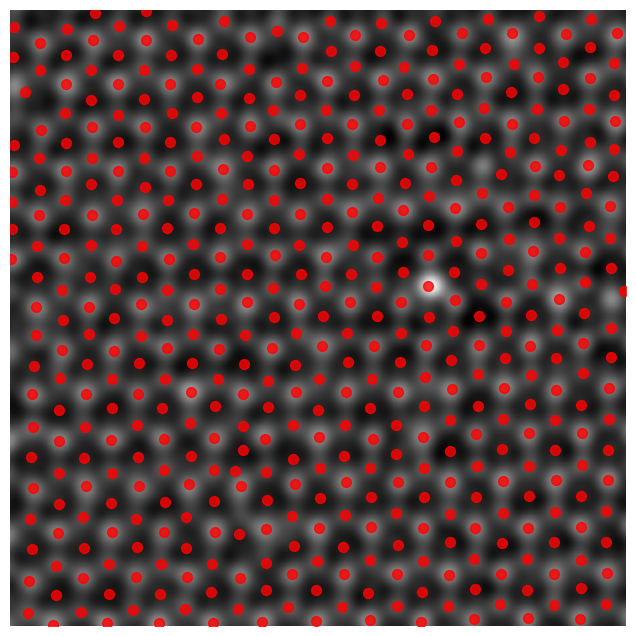

In [ ]:
# Visualize adaptive lattice sampling
adaptive_ds.plot_lattice(0, size=200, offset=(900, 500))

## Testing AdaptiveLatticeDataset

**Adaptive approach**: Estimate local lattice vectors from detected atoms and extrapolate to find neighboring sites. Adapts to drift as it grows outward!

## Testing PairedAdaptiveLatticeDataset

**Key improvements:**
- **Paired outputs**: Returns two versions of the same patch with different random rotations
- **Proper rotation handling**: Extracts patch with padding → applies transforms → rotates → crops to size
- **No artifacts**: Padding prevents black edges from rotation
- **Fixed indexing**: Added bounds checking to prevent index out of range errors

In [26]:
from livae.data import PairedAdaptiveLatticeDataset

# Create adaptive lattice dataset
pair_adaptive_ds = PairedAdaptiveLatticeDataset(images, patch_size=128, detection_threshold=0.6)
print(f"Created AdaptiveLatticeDataset with {len(adaptive_ds)} patches")

Adaptive lattice: 6017 unique sites - 4654 with atoms, 1363 empty sites
Adaptive lattice: 6026 unique sites - 4880 with atoms, 1146 empty sites
Adaptive lattice: 5595 unique sites - 4250 with atoms, 1345 empty sites
Created AdaptiveLatticeDataset with 18242 patches


PairedAdaptiveLatticeDataset size: 17638
3.583371019253848
3.622026626498891
5.024386395272596
1.502483959604462
5.155359666137707
2.871303395050307
3.518965089568558
0.5158717912402421


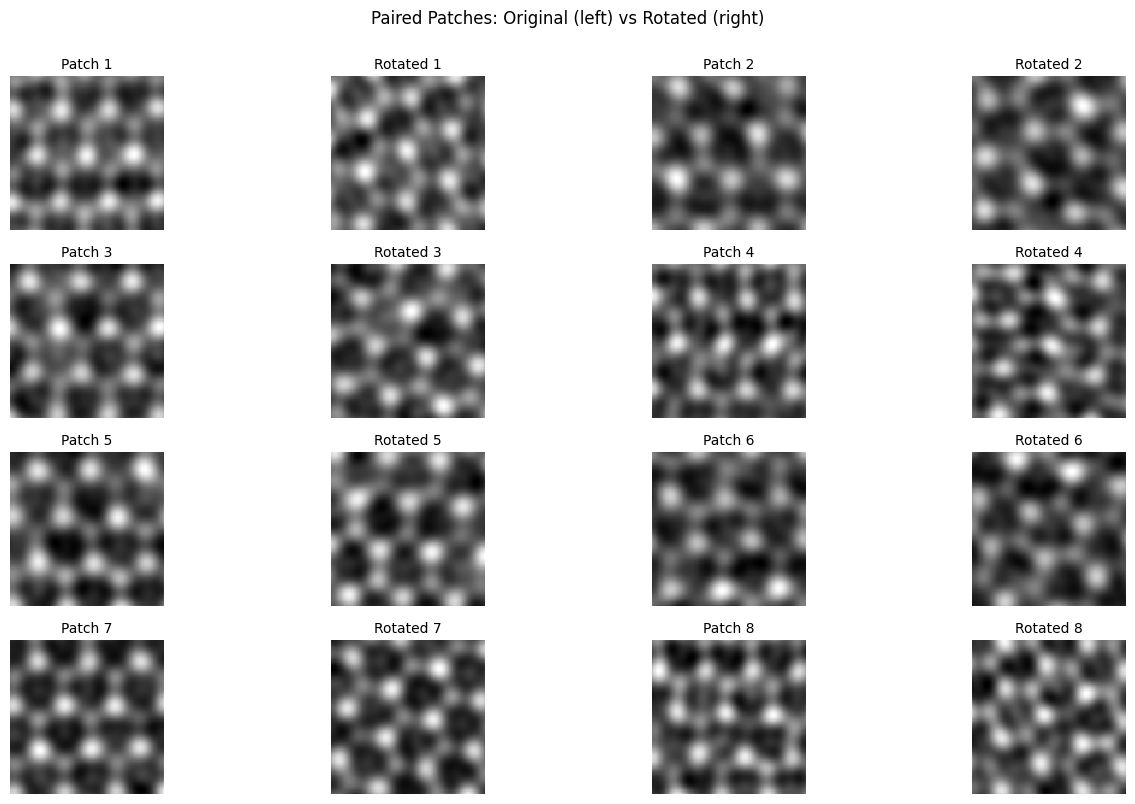


Patch 1 stats - mean: 0.370, std: 0.191
Patch 2 stats - mean: 0.393, std: 0.192


In [28]:
# Sample patches from adaptive dataset
# Verify dataset length to ensure we sample correctly
print(f"PairedAdaptiveLatticeDataset size: {len(pair_adaptive_ds)}")

fig = plt.figure(figsize=(14, 8))
for i in range(0, 16, 2):
    # Use pair_adaptive_ds length for sampling
    random_index = random.randint(0, len(pair_adaptive_ds) - 1)
    patch1, patch2, rot = pair_adaptive_ds[random_index]
    patch_img1 = patch1.squeeze()
    patch_img2 = patch2.squeeze()

    print(rot)
    
    ax = fig.add_subplot(4, 4, i + 1)
    ax.imshow(patch_img1, interpolation='none', cmap='gray')
    ax.set_title(f"Patch {i // 2 + 1}", fontsize=10)
    ax.axis("off")

    ax = fig.add_subplot(4, 4, i + 2)
    ax.imshow(patch_img2, interpolation='none', cmap='gray')
    ax.set_title(f"Rotated {i // 2 + 1}", fontsize=10)
    ax.axis("off")
    
plt.suptitle("Paired Patches: Original (left) vs Rotated (right)", fontsize=12, y=1.00)
plt.tight_layout()
plt.show()

# Verify both patches have similar intensity distributions
print(f"\nPatch 1 stats - mean: {patch_img1.mean():.3f}, std: {patch_img1.std():.3f}")
print(f"Patch 2 stats - mean: {patch_img2.mean():.3f}, std: {patch_img2.std():.3f}")

## Testing Rotation with Different Padding Values

Let's verify that sufficient padding (32 pixels) eliminates black edges during rotation, while insufficient padding (8 pixels) shows the problem.

In [12]:
# Test with insufficient padding (should show black edges)
ds_low_padding = PatchDataset(images, patch_size=128, padding=8)

# Test with sufficient padding (should NOT show black edges)  
ds_high_padding = PatchDataset(images, patch_size=128, padding=32)

print(f"Low padding dataset: {len(ds_low_padding)} patches")
print(f"High padding dataset: {len(ds_high_padding)} patches")

Preprocessing images (caching)...
Detected 4916 atoms, 4336 after edge exclusion.
Detected 4959 atoms, 4323 after edge exclusion.
Detected 4776 atoms, 4161 after edge exclusion.
Preprocessing images (caching)...
Detected 4916 atoms, 4150 after edge exclusion.
Detected 4959 atoms, 4100 after edge exclusion.
Detected 4776 atoms, 3963 after edge exclusion.
Low padding dataset: 12820 patches
High padding dataset: 12213 patches


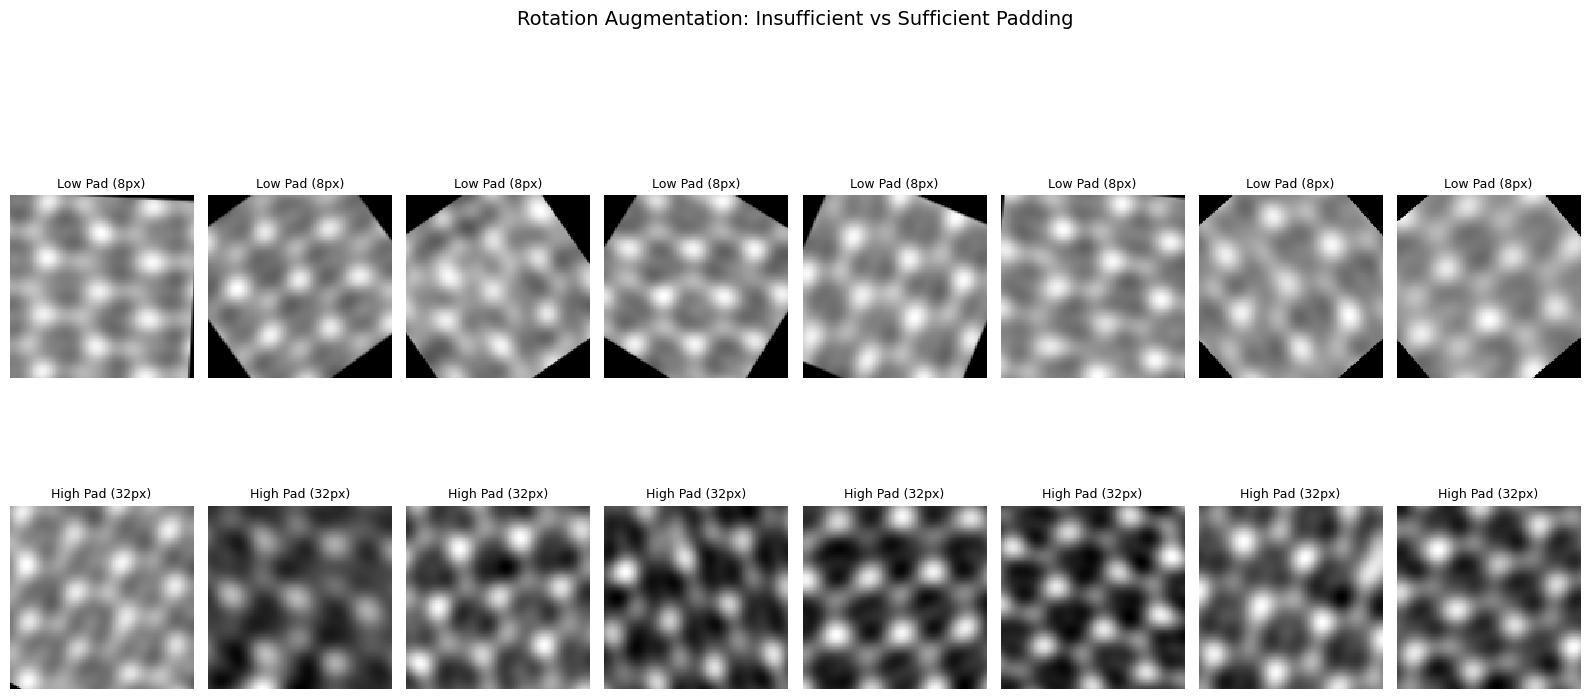

In [13]:
# Visualize comparison: Low padding vs High padding
fig = plt.figure(figsize=(16, 8))

# Sample same patches from both datasets
random.seed(42)
n_samples = 8

for i in range(n_samples):
    random_index = random.randint(0, min(len(ds_low_padding), len(ds_high_padding)) - 1)
    
    # Low padding patch (top row)
    patch_low = ds_low_padding[random_index].squeeze()
    ax1 = fig.add_subplot(2, n_samples, i + 1)
    ax1.imshow(patch_low, interpolation='none', cmap='gray')
    ax1.set_title(f"Low Pad (8px)", fontsize=9)
    ax1.axis("off")
    
    # High padding patch (bottom row)
    patch_high = ds_high_padding[random_index].squeeze()
    ax2 = fig.add_subplot(2, n_samples, n_samples + i + 1)
    ax2.imshow(patch_high, interpolation='none', cmap='gray')
    ax2.set_title(f"High Pad (32px)", fontsize=9)
    ax2.axis("off")

fig.suptitle("Rotation Augmentation: Insufficient vs Sufficient Padding", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()